# Analyzes ROC & AUC using similarity metrics for valid_data. 

- [ ] change SetUp to generate train_SouDef + train_Item df plus their valid_data versions
- [ ] change YourOwn to optionally load the extra train/valid df
- [ ] copy YourOwn to CM-AUC notebook
- [ ] create binary classifier using average or median sim scores on ONLY train
- [ ] create CM for valid df and plot
- [ ] create AUC + PrecisionRecall and plot

# Setup Environment

## Set Notebook Parameters

In [1]:
# use gDrive if you previously saved train_data, etc.
# otherwise, use pre-generated data from repos (Default)
USE_GDRIVE = False

# if using gDrive, then the path to the checkpoint folder must be specified.
# After mounting your gDrive, view /content/drive and "copy path" to FOLDER, like...
CP_PATH = '/content/drive/MyDrive/CVA-SBERT-Analyses/20221119-183356' # something like this

# save analysis plots if customized
SAVE_PLOT = False

## Import various packages


In [2]:
import pandas as pd
import numpy as np

## Clone CVA-SBERT GitHub or mount gDrive

In [7]:
import os.path
from os import path
from time import strftime, localtime
from google.colab import drive

if USE_GDRIVE:
    drive.mount('/content/drive')           # mount gDrive

else:
    !git clone https://github.com/Hackathorn/CVA-SBERT  # clone repo
    CP_PATH = '/content/CVA-SBERT/data/post_setup_data'

fatal: destination path 'CVA-SBERT' already exists and is not an empty directory.


## Read CVA datasets into ```train_data``` dataframe

In [8]:
train_data = pd.read_csv(CP_PATH+'/train_data.csv')
train_data

,DataId,SourceId,Target,Definition,Item,Cos_Sim,Euc_Sim
0,0,2978,1,People whose past behavior is consistent with ...,Have any of your current or previous partners ...,0.183756,1.277688
1,1,1056,0,Facilitation from work to school.,I enjoy being a student on this campus.,0.292208,1.189783
2,3,1015,0,Employees? sense of belongingness at work.,Helps others when it is clear their workload i...,0.322255,1.164255
3,4,2988,0,How attracted members were to the crew and the...,Managers rate each crew (low performance/high ...,0.446235,1.052393
4,7,3130,0,Things Manny didn?t do.,Did Manny tear the book while he was reading it?,0.565577,0.932119
...,...,...,...,...,...,...,...
23030,28070,12341,0,The extent to which reputations were observabl...,The project required close working relationshi...,0.213506,1.254188
23031,28071,12822,1,How characteristic each of the attractiveness ...,Wise.,0.147961,1.305403
23032,28072,3350,1,Participants' explanations for why the seller ...,The buyer is persuasive,0.569600,0.927793
23033,28074,2361,1,Newcomers? belief that good alternative work e...,To what extent have other co-workers influence...,0.447036,1.051631


RESULTS...
- DataId should match with original CSV dataset rows   # TODO - check!
- TODO - more comments on above

## Optionally load other CVA results like ```embeddings```

- Assuming USE_GDRIVE==False or optional data is from repo clone
- Other 'post_setup_data' are numpy arrays for: valid_data, embeddings, cos_sim, euc_sim


In [9]:
# ##### uncomment as appropriate

valid_data = pd.read_csv(CP_PATH+'/valid_data.csv')
# embeddings = np.load(CP_PATH+'/embeddings.npz')
# cos_sim = np.load(CP_PATH+'/cos_sim.npy')
# euc_sim = np.load(CP_PATH+'/euc_sim.npy')


In [10]:
valid_data

,DataId,SourceId,Target,Definition,Item
0,2,9900,0,The telemarketers ranked from 1 (most importan...,To upgrade physical work environments.
1,5,9900,0,The production workers ranked from 1 (most imp...,To produce error-free work.
2,6,3169,1,Informal rewards and recognition that particip...,"In the last few years (1994 to the present), h..."
3,10,2045,0,The extent to which individuals internalize ju...,[The organization] treats me with dignity and ...
4,23,9503,0,Constructing a false heterosexual identity.,"People, regardless of their sexual orientation..."
...,...,...,...,...,...
5036,28047,9417,1,Participants' personal independence and self-r...,"If you want something done right, you?ve got t..."
5037,28057,12366,0,Respondents indicated the extent to which they...,Extensive off-the-job training was provided.
5038,28059,1022,1,The quality of exchange relationships among co...,Other group members understand my problems.
5039,28062,12399,0,A supervisor rated how characteristic each of ...,I am currently engaged in my tasks because I e...


# Apply ```soc_auc_score``` with y_true from Target & y_score from [Cos-Sim, Euc-Sim]

- Note that y_score is a **probablity estimate** of Target as 0 or 1 
- However, both similarity metrics are NOT. Range is not [0,1] and 0.5 is not a true random estimate.
- What to do??????

## Setup y_true & y_score

- NOTE: valid_data DOES NOT contain similarity metrics  ######### TODO

In [16]:
# create y_true
y_true = train_data.Target.array        ######### TODO use valid_data

# create y_score
y_score = train_data.Cos_Sim.array      ######### TODO transform to probablity estimate

print("Same shape?", y_true.shape, y_score.shape)

Same shape? (23035,) (23035,)


## Display arbitrary Confusion Matrix

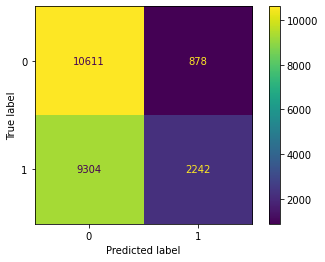

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# set arbitrary cutoff score
cutoff = 0.5

# define function to compute/display CM
def compute_CM(y_true, y_score, cutoff):
    
    # transform score to binary prediction
    y_pred = np.where(y_score > cutoff, 1, 0)

    # compute/display CM
    cm = confusion_matrix(y_true, y_pred)
    # print('CM = ', cm)
    cm_display = ConfusionMatrixDisplay(cm).plot()

compute_CM(y_true, y_score, cutoff)

## Compute/Plot ROC, PR, AUC, CM

AUC = 0.6415559912352317


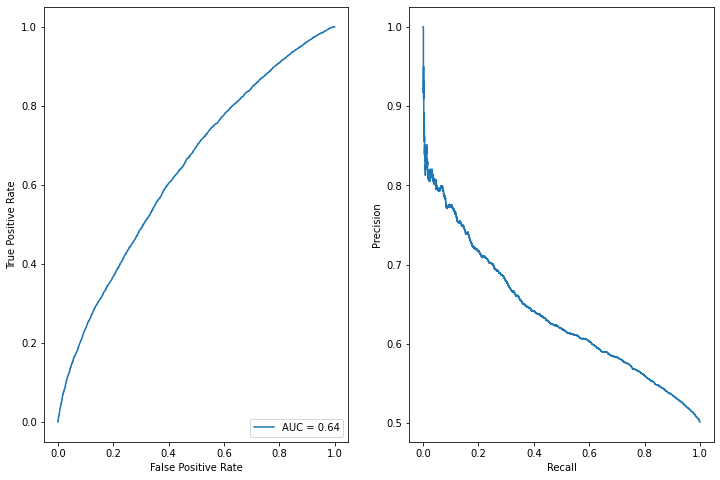

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# compute roc curve
fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print("AUC =", auc)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)

# # Compute ROC AUC score
# auc = roc_auc_score(y_true, y_score)
# print("AUC =", auc)

prec, recall, _ = precision_recall_curve(y_true, y_score)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

## Find the optimal threshold from ROC and its CM

- _The optimal cut off point would be where “true positive rate” is high and the “false positive rate” is low._
- Ref: https://stackoverflow.com/questions/56203889/how-to-get-the-optimal-threshold-from-roc-curve-in-python

Optimal Cutoff =  0.3001006543636322


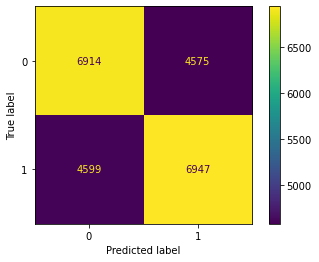

In [37]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

cutoff = Find_Optimal_Cutoff(y_true, y_score)[0]
print("Optimal Cutoff = ", cutoff)
compute_CM(y_true, y_score, cutoff)

RESULTS...
- Slightly better than random ??? 